# Background:

The CIFAR-10 dataset consists of 60,000 32x32x3 (RGB) images in 10 classes, with 6,000 images per class. There are 50,000 training images (5,000 per class) and 10,000 test images. 

### Fun fact: 
When the dataset was created, students were paid to label all of the images
***

# The Imports:

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import Augmentor
from PIL import Image
import cv2
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tnrange,tqdm_notebook, tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from google.colab.patches import cv2_imshow

# Plot samples from the training data:

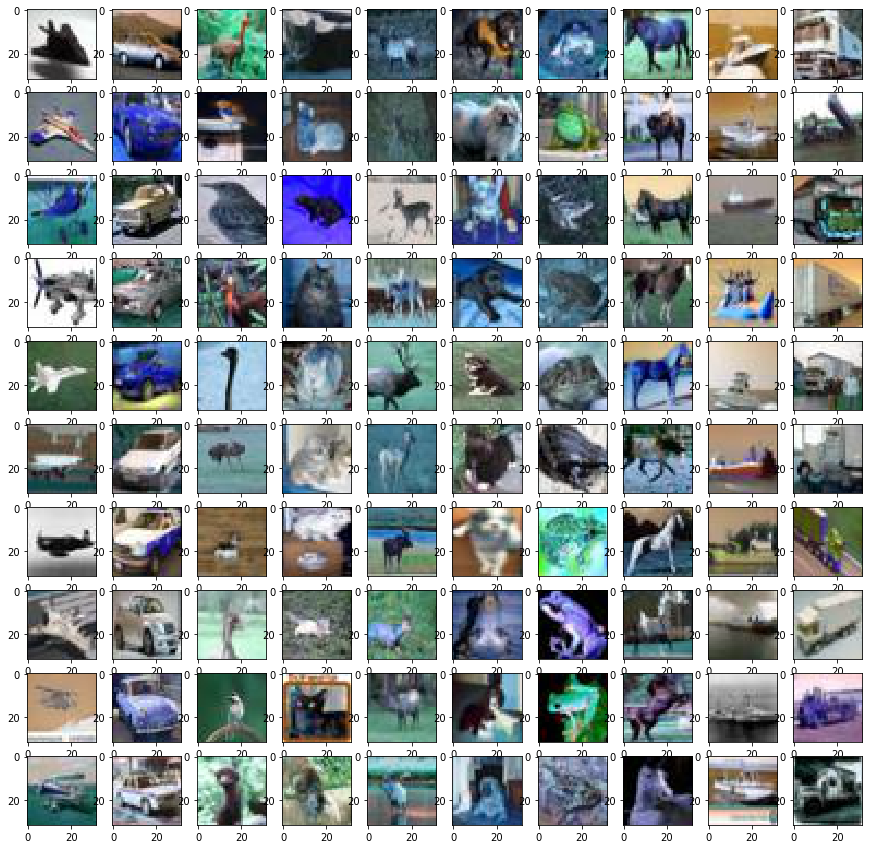

<Figure size 720x216 with 0 Axes>

In [18]:
#not_augmented
fig, axs = plt.subplots(10, 10, figsize=(15,15))
fig = plt.figure(figsize=(10,3))


class_list=['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    for j in range(10):
        zeroes="000"
        jpg=".jpg"
        slash = "/"
        path = './CIFAR-10-images/train/'+ str(class_list[i]) + slash + zeroes + str(j) + jpg
        #print(path)
        img2 = cv2.imread(path)
        axs[j,i].imshow(img2)
        
        # img2*2 causes chaos
     
        

In [19]:
def show_image_by_num(path):
    path = str(path)
    path0="./CIFAR-10-images/train/airplane/"
    path2=".jpg"
    path = path0 + path + path2
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)), interpolation='sinc')

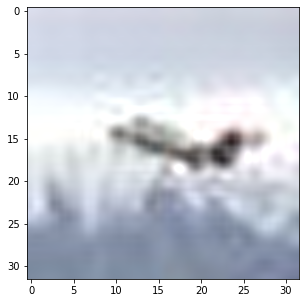

In [20]:
show_image_by_num("0235")

## Augment and transform training data:
The training images are:
1. Randomly mirrored (probability=0.9)
2. Randomly Rotated (probability=0.9, max_right=16, max_left=16)
3. Zoomed randomly (probability=0.8, scaling=0.9)

In [22]:
p = Augmentor.Pipeline()
p.flip_left_right(probability=0.9)
p.rotate(probability=0.7, max_left_rotation=16, max_right_rotation=16)
p.zoom_random(0.8, percentage_area=0.9)

In [23]:
transformations = transforms.Compose([
    p.torch_transform(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


transformations_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder("./CIFAR-10-images/train/", transform = transformations)
train_loader = DataLoader(dataset = train_dataset, batch_size = 32,shuffle=True)
items = iter(train_loader)
image, label = items.next()


test_dataset = torchvision.datasets.ImageFolder("./CIFAR-10-images/test/", transform=transformations_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False)




print(len(train_dataset))

50000


# Plot samples from the Train_loader:

* The images pass through the augmentor pipeline.
* The images are unnormalised before plotting.
* If not, you'll get funky colors.

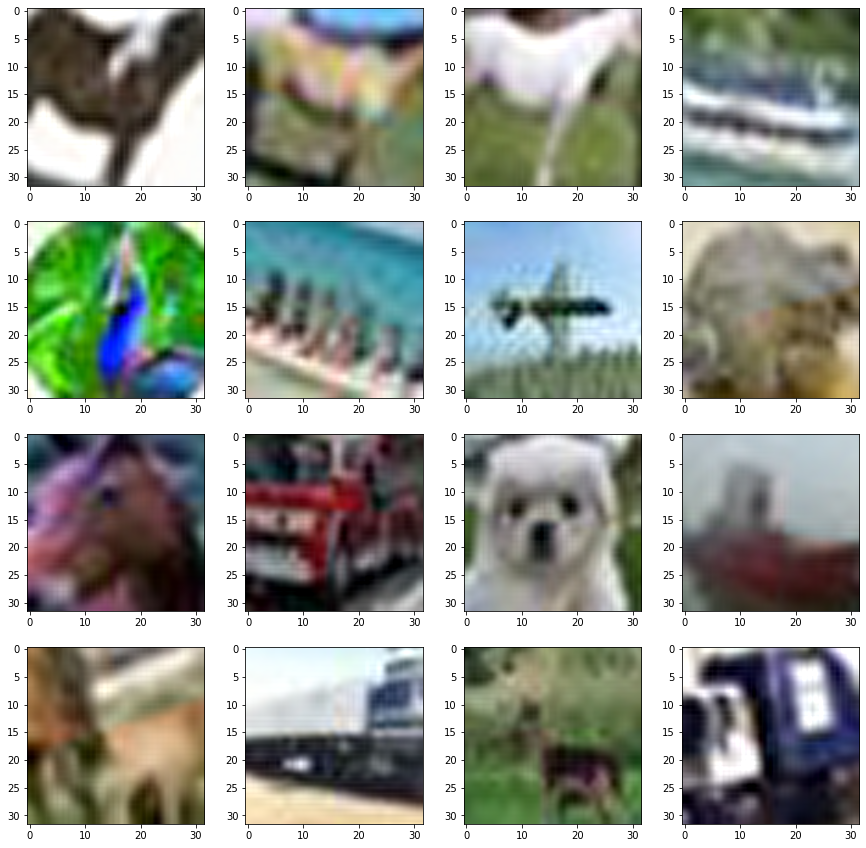

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [24]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (train_loader):
            np_image=image_list[0][0] # has len 3
            #print(len(np_image))
            x=np.transpose(np_image, (1, 2, 0))
            unnormalised_x = x / 2 + 0.5 
            axs[j,i].imshow(unnormalised_x, interpolation='sinc')
            break
            
plt.show()

 # [[ { 3lists }, {3lists}, {3lists}, ...64_times} ],   [ {label}, {label}, {label}, ...64_times} ]]   

# The Model:

In [ ]:
num_classes=10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels and will convolve 6 filters each of size 3x5x5. Output = 6x28x28
        self.pool = nn.MaxPool2d(2, 2)  #6x28x28 to 6x14x14.
        self.conv2 = nn.Conv2d(6, 16, 5)# 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

# Building The Training Loop:

In [ ]:
# try 60 epochs
num_epochs=65

loss_list=[]
for epoch in tnrange(num_epochs):  
    
    running_loss = 0.0
    for thing in tqdm_notebook(train_loader):
            images, labels=thing[0],thing[1]
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


    print("epoch: ", epoch, "Loss: ", loss)
    loss_list.append(loss)
                
print('Finished Training')

 # [[ { 3lists }, {3lists}, {3lists}, ...64_times} ],   [ {label}, {label}, {label}, ...64_times} ]]   

## Save the trained model:

In [ ]:
torch.save(net.state_dict(), 'CIFAR_model_0_colab.pt')

## Load model:

In [ ]:
net.load_state_dict(torch.load('CIFAR_model_0_colab.pt'))

## Visualise Loss through training epochs:

In [ ]:
plt.plot([a for a in range(num_epochs)], loss_list)

# To Do:
1. Make sure the test loader works fine.
2. Find out the test accuracy.
3. Compare with traiin accuracy (overfitting?).